<a href="https://colab.research.google.com/github/Curiousss/EVA/blob/master/Assignment7/Assignment7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
import tensorflow as tf
from keras.regularizers import l2
from keras.layers import SeparableConv2D, Input, Concatenate, Add


from keras.models import Model


Using TensorFlow backend.


In [2]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 11s 0us/step


In [3]:
print(train_features[0].shape)
print(num_classes)

(32, 32, 3)
10


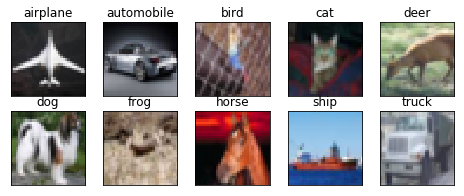

In [4]:

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [8]:
# Define the model

# input size 32
inputs=Input((32, 32, 3))

#------------------------------
# GROUP CONVOLUTION PART 1
# RF 3
# input size  32
from keras.layers import Lambda, GlobalMaxPooling2D
def Space2Depth(x):
  return tf.space_to_depth(x, block_size=2, name=None, data_format='NHWC') 
  

x1 = SeparableConv2D(64,  kernel_size=(5, 5), border_mode='same', activation ='relu')(inputs)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.2)(x1)

x2 = Convolution2D(64,  kernel_size=(5, 5), border_mode='same', activation ='relu')(x1)
x2 = BatchNormalization()(x2)
x2 = Dropout(0.2)(x2)

x3 = Convolution2D(64,  kernel_size=(5, 5), border_mode='same', activation ='relu')(x2)
x3 = BatchNormalization()(x3)
x3 = Dropout(0.2)(x3)

x1x3 = Concatenate()([x1, x3])

x4 = SeparableConv2D(64,  kernel_size=(5, 5), border_mode='same', activation ='relu')(x1x3)
x4 = BatchNormalization()(x4)
x4 = Dropout(0.2)(x4)

x1x4 = Concatenate()([x1, x4])

x5 = MaxPooling2D(pool_size=(2, 2))(x1x4)

x6 = SeparableConv2D(64,  kernel_size=(3, 3), border_mode='same', activation ='relu')(x5)
x6 = BatchNormalization()(x6)
x6 = Dropout(0.2)(x6)

x1 = Lambda(Space2Depth)(x1)
x4 = Lambda(Space2Depth)(x4)

x1x4x6 = Concatenate()([x1, x4, x6])

x7 = Convolution2D(64,  kernel_size=(5, 5), border_mode='same', activation ='relu')(x1x4x6)
x7 = BatchNormalization()(x7)
x7 = Dropout(0.2)(x7)

x3 = Lambda(Space2Depth)(x3)

x3x4x6x7 = Concatenate()([x3, x4, x6, x7])

x8 = SeparableConv2D(64,  kernel_size=(3, 3), border_mode='same', activation ='relu')(x3x4x6x7)
x8 = BatchNormalization()(x8)
x8 = Dropout(0.2)(x8)

x1x3x4x6x7x8 = Concatenate()([x1, x3, x4, x6, x7, x8])

x9 = SeparableConv2D(64,  kernel_size=(5, 5), border_mode='same', activation ='relu')(x1x3x4x6x7x8)
x9 = BatchNormalization()(x9)
x9 = Dropout(0.2)(x9)

x = Concatenate()([x1, x4, x6, x8, x9])

x10 = MaxPooling2D(pool_size=(2, 2))(x9)

x7 = Lambda(Space2Depth)( x7)

x7x10 = Concatenate()([x7,x10])

x11 = Convolution2D(64,  kernel_size=(5, 5), border_mode='same', activation ='relu')(x7x10)
x11 = BatchNormalization()(x11)
x11 = Dropout(0.2)(x11)

x2 = Lambda(Space2Depth)(x2)
x2 = Lambda(Space2Depth)(x2)
x4 = Lambda(Space2Depth)(x4)
x8 = Lambda(Space2Depth)(x8)

x2x4x8x11 = Concatenate()([x2, x4, x8, x11])

x12 = SeparableConv2D(64,  kernel_size=(5, 5), border_mode='same', activation ='relu')(x2x4x8x11)
x12 = BatchNormalization()(x12)
x12 = Dropout(0.2)(x12)

x3 = Lambda(Space2Depth)(x3)
x6 = Lambda(Space2Depth)(x6)

x2x3x6x11x12 = Concatenate()([x2, x3, x6, x11, x12])
x13 = Convolution2D(64,  kernel_size=(3, 3), border_mode='same', activation ='relu')(x2x3x6x11x12)
x13 = BatchNormalization()(x13)
x13 = Dropout(0.2)(x13)

x1 = Lambda(Space2Depth)(x1)

x1x3x4x6x8x12x13 = Concatenate()([x1, x3, x4, x6, x8, x12, x13])

x14 = SeparableConv2D(10,  kernel_size=(5, 5), border_mode='same', activation ='relu')(x1x3x4x6x8x12x13)
x14 = BatchNormalization()(x14)
x14 = Dropout(0.2)(x14)

x= GlobalMaxPooling2D()(x14)
x = Activation('softmax')(x)

model = Model(inputs=inputs, outputs=x)

model.summary()


W0621 04:28:39.807906 140645945030528 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0621 04:28:39.854181 140645945030528 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(64, kernel_size=(5, 5), activation="relu", padding="same")`
  if sys.path[0] == '':
W0621 04:28:39.870773 140645945030528 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0621 04:28:39.934459 140645945030528 deprecation_

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
separable_conv2d_1 (SeparableCo (None, 32, 32, 64)   331         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 64)   256         separable_conv2d_1[0][0]         
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 32, 32, 64)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_1 (

In [9]:
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
def scheduler(epoch, lr):
  return round(0.003 * 1/(1 + 0.319 * epoch), 10)

checkpoint = ModelCheckpoint('modelBest.h5', verbose=1, monitor='val_acc',save_best_only=True, mode='auto') 

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

W0621 04:28:44.576802 140645945030528 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=<keras_pre..., validation_steps=100, verbose=1, callbacks=[<keras.ca..., steps_per_epoch=390, epochs=100)`
W0621 04:28:55.609604 140645945030528 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will

Epoch 1/100


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '



Epoch 00001: LearningRateScheduler setting learning rate to 0.003.
390/390 [==============================] - 172s 442ms/step - loss: 1.4020 - acc: 0.4995 - val_loss: 1.1373 - val_acc: 0.5950

Epoch 00001: val_acc improved from -inf to 0.59500, saving model to modelBest.h5
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 0.0022744503.
390/390 [==============================] - 165s 424ms/step - loss: 0.9171 - acc: 0.6790 - val_loss: 0.8652 - val_acc: 0.7022

Epoch 00002: val_acc improved from 0.59500 to 0.70219, saving model to modelBest.h5
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to 0.0018315018.
390/390 [==============================] - 164s 421ms/step - loss: 0.7053 - acc: 0.7575 - val_loss: 0.7124 - val_acc: 0.7609

Epoch 00003: val_acc improved from 0.70219 to 0.76094, saving model to modelBest.h5
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to 0.0015329586.
390/390 [==============================] - 1

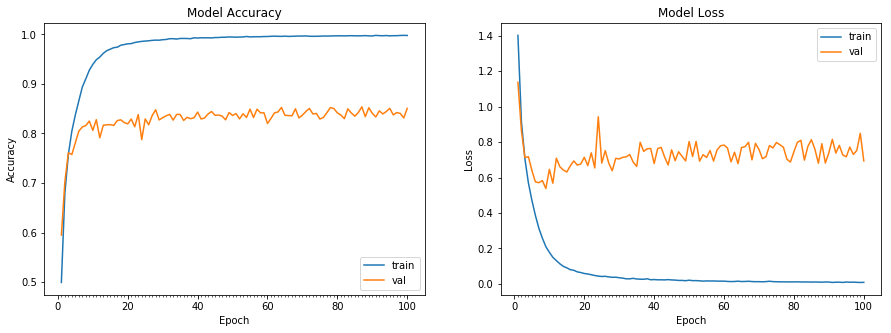

Accuracy on test data is: 84.07


In [10]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False,
                            featurewise_center=True,
                            featurewise_std_normalization=True)

testgen = ImageDataGenerator(featurewise_center=True,
                            featurewise_std_normalization=True)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = testgen.flow(test_features, test_labels), validation_steps=100, verbose=1,
                                 callbacks=[LearningRateScheduler(scheduler, verbose=1), checkpoint])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

In [0]:
modelBest = load_model("modelBest.h5")